In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest
from skimage.io import imread
from pandas.api.types import CategoricalDtype



In [2]:
analysis_data = pd.DataFrame()
analysis_path = plb.Path('C:/_2021_08_screen/MS1/ia_927/')

In [6]:
analysis_data = pd.read_csv('C:/Users/Emily/Documents/_2021_08_screen/MS1/ia_927/MS1.csv', index_col=0)
analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object
0,1A,324.0,0.132867,NaN,NaN,MS1_006,3028.0,NaN,False
1,1B,266.0,0.044643,NaN,NaN,MS1_006,3019.0,NaN,True
2,1C,209.0,0.067416,NaN,NaN,MS1_006,3009.0,NaN,True
3,1D,343.0,-0.082508,NaN,NaN,MS1_006,3013.0,NaN,False
4,2A,194.0,0.793103,NaN,NaN,MS1_006,3049.0,NaN,True


In [4]:
#depricated chunk
for dat in analysis_path.glob('MS*.csv'):
    hold = pd.read_csv(dat, index_col=0)
    analysis_data = pd.concat([analysis_data, hold], axis=0)
    
analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object
0,1A,324.0,0.132867,NaN,NaN,MS1_006,3028.0,NaN,False
1,1B,266.0,0.044643,NaN,NaN,MS1_006,3019.0,NaN,True
2,1C,209.0,0.067416,NaN,NaN,MS1_006,3009.0,NaN,True
3,1D,343.0,-0.082508,NaN,NaN,MS1_006,3013.0,NaN,False
4,2A,194.0,0.793103,NaN,NaN,MS1_006,3049.0,NaN,True


In [9]:
metadata = pd.read_csv('C:/Users/Emily/Documents/_2021_08_screen/MS1/data/20210812_metadata.csv', index_col=0)
metadata.head()

,Recorder,Plate ID,Different strains in each well of a single assay plate? (Y/N),Different compounds in each well of a single assay plate? (Y/N),Compound library ID,Compound Well A,Compound Well B,Compound Well C,Compound Well D,Temp (C),Humidity,Chemotaxis Start (24 hrs format),Chemotaxis End (24 hrs format),Image ID,Scanner Slot:,Scanner #,Strain Well A,Strain Well B,Strain Well C,Strain Well D
Date:,,,,,,,,,,,,,,,,,,,,
08/12/21,Emily,MS1_R1_001,N,Y,1-1,B2,B3,B4,B5,NaN,NaN,NaN,NaN,MS1_001,1,NaN,NaN,NaN,NaN,NaN
08/12/21,Hodan,MS1_R1_008,N,Y,1-2,B2,B3,B4,B5,NaN,NaN,NaN,NaN,MS1_002,4,NaN,NaN,NaN,NaN,NaN
08/12/21,Emily,MS1_R1_002,N,Y,1-1,C2,C3,C4,C5,NaN,NaN,NaN,NaN,MS1_001,2,NaN,NaN,NaN,NaN,NaN
08/12/21,Emily,MS1_R1_003,N,Y,1-1,D2,D3,D4,D5,NaN,NaN,NaN,NaN,MS1_001,3,NaN,NaN,NaN,NaN,NaN
08/12/21,EMILY,MS1_R1_004,N,Y,1-1,E2,E3,E4,E5,NaN,NaN,NaN,NaN,MS1_001,4,NaN,NaN,NaN,NaN,NaN


In [10]:
# Breaking up the slot and well info to use for unblinding the compound data
for index, row in analysis_data.iterrows():
    analysis_data['Slot']= analysis_data['WellNo'].astype(str).str[0]
    analysis_data['Well']= analysis_data['WellNo'].astype(str).str[1]

# Adding the plate ID to the image analysis results
def add_pid(row, image_metdat):
    pid = image_metdat.loc[(image_metdat['Image ID']==row['File Name']) 
                           & (image_metdat['Scanner Slot:'].astype(str)==row['Slot'])]['Plate ID']
    return pid

In [11]:
analysis_data['Plate ID']=analysis_data.apply(
    lambda row: add_pid(row, metadata), axis=1)
analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well
0,1A,324.0,0.132867,NaN,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A
1,1B,266.0,0.044643,NaN,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B
2,1C,209.0,0.067416,NaN,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C
3,1D,343.0,-0.082508,NaN,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D
4,2A,194.0,0.793103,NaN,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A


In [12]:
# Creating a function to map the compound key to the automated image analysis
# results
def f(x):
    return {
        'A': 'Compound Well A',
        'B': 'Compound Well B',
        'C': 'Compound Well C',
        'D': 'Compound Well D',
    }[x]

def add_compound(row, image_metdat):
    well=row['Well']
    dat = image_metdat.loc[image_metdat['Plate ID']==row['Plate ID']][f(well)]
    return dat.values[0]

analysis_data['Compound']=analysis_data.apply(
    lambda row: add_compound(row, metadata), axis=1)

analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well
0,1A,324.0,0.132867,B2,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A
1,1B,266.0,0.044643,B3,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B
2,1C,209.0,0.067416,B4,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C
3,1D,343.0,-0.082508,B5,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D
4,2A,194.0,0.793103,C2,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A


In [13]:
def add_compound_plate(row, image_metdat):
    comp_plate = image_metdat.loc[image_metdat['Plate ID'] == row['Plate ID']]['Compound library ID']
    return comp_plate

analysis_data['Compound Library ID']=analysis_data.apply(
    lambda row: add_compound_plate(row, metadata), axis=1)
analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Library ID
0,1A,324.0,0.132867,B2,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A,1-4
1,1B,266.0,0.044643,B3,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B,1-4
2,1C,209.0,0.067416,B4,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C,1-4
3,1D,343.0,-0.082508,B5,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D,1-4
4,2A,194.0,0.793103,C2,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A,1-4


In [14]:
def flip(row):
    id = row['Compound']
    flipped = id[::-1]
    #print(flipped)
    return(flipped)

analysis_data['Compound']=analysis_data.apply(
    lambda row: flip(row), axis=1)

In [15]:
compound_data = pd.read_csv('C:/Users/Emily/Documents/_2021_08_screen/MS1/compounds/comp_plate_map.csv', index_col=0)
compound_data.head()

,Num,Let,Compounds,Compound Well,Plate Number
0,2,B,IA,2B,1-1
1,3,B,DI,3B,1-1
2,4,B,DI,4B,1-1
3,5,B,EMT,5B,1-1
4,2,C,DI,2C,1-1


In [16]:
analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Library ID
0,1A,324.0,0.132867,2B,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A,1-4
1,1B,266.0,0.044643,3B,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B,1-4
2,1C,209.0,0.067416,4B,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C,1-4
3,1D,343.0,-0.082508,5B,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D,1-4
4,2A,194.0,0.793103,2C,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A,1-4


In [17]:
def unblind(row, comp_dat):
    comp_name = comp_dat.loc[(comp_dat['Compound Well'] == row['Compound']) & 
                             (comp_dat['Plate Number'] == row['Compound Library ID'])]['Compounds']
    return comp_name.values[0]
    

analysis_data['Compound Name']=analysis_data.apply(
    lambda row: unblind(row, compound_data), axis=1)

analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Library ID,Compound Name
0,1A,324.0,0.132867,2B,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A,1-4,EMT
1,1B,266.0,0.044643,3B,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B,1-4,Benz
2,1C,209.0,0.067416,4B,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C,1-4,EMT
3,1D,343.0,-0.082508,5B,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D,1-4,DI
4,2A,194.0,0.793103,2C,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A,1-4,DI


In [18]:
analysis_data=analysis_data.replace('Benz', '1-Oct')


In [19]:
analysis_data.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Library ID,Compound Name
0,1A,324.0,0.132867,2B,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A,1-4,EMT
1,1B,266.0,0.044643,3B,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B,1-4,1-Oct
2,1C,209.0,0.067416,4B,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C,1-4,EMT
3,1D,343.0,-0.082508,5B,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D,1-4,DI
4,2A,194.0,0.793103,2C,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A,1-4,DI


In [20]:
ms2 = pd.read_csv('C:/Users/Emily/Documents/_2021_08_screen/MS2/MS2.csv', index_col=0)
ms2_md = pd.read_csv('C:/Users/Emily/Documents/_2021_08_screen/MS2/MS2_md.csv', index_col=0)

ms2_md = ms2_md.drop(columns=['Scanner Slot'])

# Breaking up the slot and well info to use for unblinding the compound data
for index, row in ms2.iterrows():
    ms2['Slot']= ms2['WellNo'].astype(str).str[0]
    ms2['Well']= ms2['WellNo'].astype(str).str[1]


In [21]:

ms2['Plate ID']=ms2.apply(
    lambda row: add_pid(row, ms2_md), axis=1)
ms2.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well
0,1A,219.0,0.193548,NaN,NaN,MS2_001,3012.0,MS2_R1_1,True,1,A
1,1B,215.0,-0.021739,NaN,NaN,MS2_001,3018.0,MS2_R1_1,True,1,B
2,1C,262.0,0.009091,NaN,NaN,MS2_001,3034.0,MS2_R1_1,False,1,C
3,1D,232.0,-0.049020,NaN,NaN,MS2_001,3028.0,MS2_R1_1,False,1,D
4,2A,194.0,-0.024691,NaN,NaN,MS2_001,3064.0,MS2_R1_2,False,2,A


In [22]:
ms2['Compound']=ms2.apply(
    lambda row: add_compound(row, ms2_md), axis=1)
ms2['Compound Name'] = ms2['Compound']
ms2.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Name
0,1A,219.0,0.193548,MT,NaN,MS2_001,3012.0,MS2_R1_1,True,1,A,MT
1,1B,215.0,-0.021739,MT,NaN,MS2_001,3018.0,MS2_R1_1,True,1,B,MT
2,1C,262.0,0.009091,MT,NaN,MS2_001,3034.0,MS2_R1_1,False,1,C,MT
3,1D,232.0,-0.049020,MT,NaN,MS2_001,3028.0,MS2_R1_1,False,1,D,MT
4,2A,194.0,-0.024691,MT,NaN,MS2_001,3064.0,MS2_R1_2,False,2,A,MT


In [23]:
frames = [analysis_data, ms2]
all_msDat = pd.concat(frames)
all_msDat.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Library ID,Compound Name
0,1A,324.0,0.132867,2B,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A,1-4,EMT
1,1B,266.0,0.044643,3B,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B,1-4,1-Oct
2,1C,209.0,0.067416,4B,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C,1-4,EMT
3,1D,343.0,-0.082508,5B,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D,1-4,DI
4,2A,194.0,0.793103,2C,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A,1-4,DI


In [24]:
all_msDat=all_msDat.replace('MT', 'EMT:EMT')
all_msDat=all_msDat.replace('EMT', 'DMSO:EMT')
all_msDat=all_msDat.replace('DMSO', 'DMSO:DMSO')
all_msDat.head()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Library ID,Compound Name
0,1A,324.0,0.132867,2B,NaN,MS1_006,3028.0,MS1_R1_013,False,1,A,1-4,DMSO:EMT
1,1B,266.0,0.044643,3B,NaN,MS1_006,3019.0,MS1_R1_013,True,1,B,1-4,1-Oct
2,1C,209.0,0.067416,4B,NaN,MS1_006,3009.0,MS1_R1_013,True,1,C,1-4,DMSO:EMT
3,1D,343.0,-0.082508,5B,NaN,MS1_006,3013.0,MS1_R1_013,False,1,D,1-4,DI
4,2A,194.0,0.793103,2C,NaN,MS1_006,3049.0,MS1_R1_014,True,2,A,1-4,DI


In [16]:
#analysis_data.to_csv('/Volumes/LaCie/_2021_08_screen/practice_run/MS1_analysis.csv')

In [17]:
summary_data = analysis_data.groupby(['Compound Name']).mean()

In [18]:
#summary_data = summary_data.drop(['Large Object'], axis=1)

#summary_data.to_csv('D:/_2021_08_screen/practice_run/data/RefComps_sumstats.csv')

In [19]:
#summary_data = pd.read_csv('D:/_2021_08_screen/practice_run/data/RefComps_sumstats.csv')

In [25]:
all_msDat.tail()

,WellNo,Total Worms,Chemotaxis,Compound,Strain,File Name,Well width,Plate ID,Large Object,Slot,Well,Compound Library ID,Compound Name
11,3D,152.0,0.134752,DMSO:H2O,NaN,MS2_002,3067.0,MS2_R1_7,False,3,D,NaN,DMSO:H2O
12,4A,165.0,-0.077922,DMSO:H2O,NaN,MS2_002,3037.0,MS2_R1_8,False,4,A,NaN,DMSO:H2O
13,4B,266.0,-0.177966,DMSO:H2O,NaN,MS2_002,3027.0,MS2_R1_8,False,4,B,NaN,DMSO:H2O
14,4C,201.0,-0.111111,DMSO:H2O,NaN,MS2_002,3030.0,MS2_R1_8,False,4,C,NaN,DMSO:H2O
15,4D,211.0,-0.045685,DMSO:H2O,NaN,MS2_002,3032.0,MS2_R1_8,False,4,D,NaN,DMSO:H2O


FileNotFoundError: No such file: 'D:\_2021_08_screen\practice_run\representatives\DMSO.tiff'

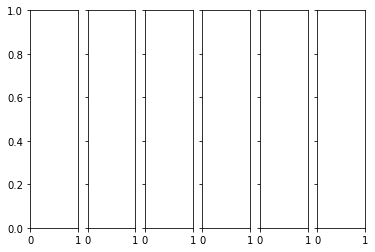

In [17]:
ref_list = ['DMSO', 'Empty', 'DI', 'IA', '2-no', '1-oct']

impath = 'D:/_2021_08_screen/practice_run/representatives/'
image_folder = plb.Path(impath)

labels = ['Compound', '', '', 'Start Zone', '', '', 'Solvent']
ticks = [0.0, 500.0, 1000.0, 1500.0, 2000.0, 2500.0, 3000.0]
fig, axes = plt.subplots(nrows=1, ncols=6, sharey=True, sharex=True)


col = 0
row = 1
for i in ref_list:
#im in image_folder.glob('[!._]*.tif*'):
    
    im = image_folder.joinpath(i + '.tiff')
    img = imread(im)
    center = (img.shape[0])/2
    fname = im.stem
    axes[col].imshow(img/255, cmap='gray')
    axes[col].set_title(fname)
    #axes[col].axis('off')
    axes[col].xaxis.set_visible(False)
    axes[col].axhline(y=center, color='r', linestyle='--')
    
    #a=axes[col].get_yticks().tolist()
    #print(a)
    axes[col].set_yticks(ticks)
    axes[col].set_yticklabels(labels)
    axes[col].tick_params(axis=u'both', which=u'both',length=0)
    
    col += 1

#fig.savefig('D:/_2021_08_screen/practice_run/figs/plot.tiff', dpi=1200)

In [29]:
wrm_locs_fldr = plb.Path('C:/Users/Emily/Documents/_2021_08_screen/MS1/ia/')

In [30]:
def get_worm_locs(row, wrms, result_dict): 

    fname = row['File Name']
    wellnum = row['WellNo']
    loc_fname =  wrms.joinpath('loc_' + fname + '_' + wellnum + '.csv')
    temp = pd.read_csv(loc_fname)
    compound = row['Compound Name']
    xs = temp['X']
    #xs = list(temp['centroid-1'])
    if compound in result_dict:
        result_dict[compound] = result_dict[compound].append(xs)
        result_dict[compound].reset_index(inplace=True, drop=True)
        #result_dict[compound] = result_dict[compound]+xs
    else:
        result_dict[compound]=xs
    
    return result_dict

ref_dict = {}
for index, row in all_msDat.iterrows():
    ref_locs = get_worm_locs(row, wrm_locs_fldr, ref_dict)
ref_df = pd.DataFrame.from_dict(ref_dict)
ref_df.head()

,DMSO:EMT,1-Oct,DI,DMSO:DMSO,IA,2no,EMT:EMT,DMSO:H2O
0,2078,2681.0,2329.0,1201.0,405.0,2061.0,2277.403509,2426.912467
1,1803,2309.0,1952.0,1406.0,482.0,1448.0,1669.698039,2648.373684
2,1740,1884.0,2377.0,2240.0,1320.0,1354.0,1886.927273,2185.078212
3,2023,1348.0,1891.0,808.0,886.0,687.0,552.927184,1989.336538
4,368,1329.0,2137.0,2674.0,1356.0,1078.0,1193.569444,1139.697987


In [31]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm
#pixels per milimeter
px_mm

mm_df = ref_df.apply(lambda x: -(x/px_mm)+32.5)

In [32]:
mm_df.head()

,DMSO:EMT,1-Oct,DI,DMSO:DMSO,IA,2no,EMT:EMT,DMSO:H2O
0,-11.484333,-24.247833,-16.797167,7.078833,23.927500,-11.124500,-15.705041,-18.869647
1,-5.663500,-16.373833,-8.817333,2.739667,22.297667,1.850667,-2.841942,-23.557243
2,-4.330000,-7.378000,-17.813167,-14.913333,4.560000,3.840333,-7.439961,-13.750822
3,-10.320167,3.967333,-7.526167,15.397333,13.746333,17.958500,20.796375,-9.607623
4,24.710667,4.369500,-12.733167,-24.099667,3.798000,9.682333,7.236113,8.376393


In [35]:
mm_df.to_csv('C:/Users/Emily/Documents/_2021_08_screen/ms1_ms2_x.csv')
#ref_df = pd.read_csv('D:/_2021_08_screen/practice_run/wormX_ref_comps.csv')

In [67]:
ref_comps=['DMSO:DMSO', 'DMSO:EMT', 'EMT:EMT', 'DMSO:H2O', 'DI', 'IA', '1-Oct', '2no']
color_dict={'DMSO:DMSO':'#5e4fa2', 'DMSO:EMT':'#5e4fa2', 'EMT:EMT':'#5e4fa2','DMSO:H2O':'#5e4fa2','DI':'#66c2a5', 'IA':'#66c2a5', '1-Oct':'#fdae61', '2no':'#fdae61'}

In [68]:
mm_refs_obj = dabest.load(mm_df, idx=(ref_comps))

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


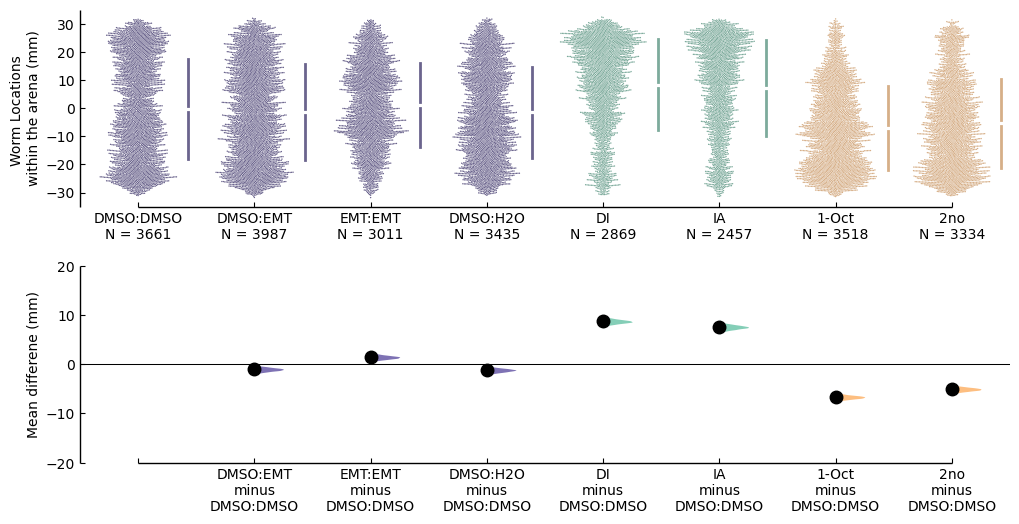

In [69]:
mm_refs_plot = mm_refs_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35), custom_palette=color_dict)
rawswarm_axes = mm_refs_plot.axes[0]
contrast_axes = mm_refs_plot.axes[1]

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in')

#contrast_axes.remove()
contrast_axes.yaxis.set_tick_params(tickdir='in')
contrast_axes.xaxis.set_tick_params(tickdir='in')



In [70]:
#mm_refs_plot.savefig('D:/_2021_08_screen/practice_run/20210812_conf_int.svg')
mm_refs_plot.savefig('D:/_2021_08_screen/practice_run/20220208_conf_int.png')

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\ipykernel_launcher.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


In [34]:
ms1_CI_results = mm_refs_obj.mean_diff.results

In [31]:
ms1_CI_results.to_csv('D:/_2021_08_screen/practice_run/ms1_CI_results.csv')

In [25]:
ref_comps=['EMT', 'DMSO', 'DI', 'IA', '1-Oct', '2no']
color_dict={'EMT':'#5e4fa2', 'DMSO':'#5e4fa2','DI':'#66c2a5', 'IA':'#66c2a5', '1-Oct':'#fdae61', '2no':'#fdae61'}

In [26]:
mm_emt_obj = dabest.load(mm_df, idx=(ref_comps))

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


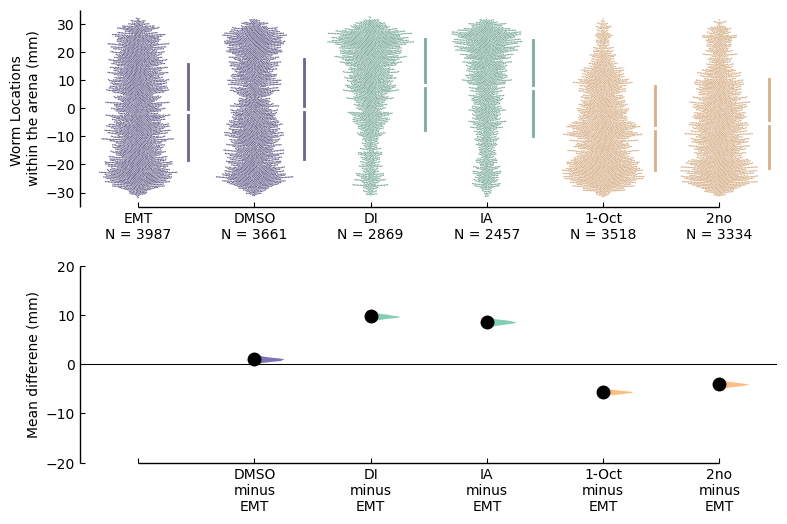

In [28]:
mm_emt_plot = mm_emt_obj.mean_diff.plot(raw_marker_size=1, swarm_label = 'Worm Locations \nwithin the arena (mm)', 
                                        contrast_label="Mean differene (mm)", contrast_ylim = (-20,20), swarm_ylim=(-35,35), custom_palette=color_dict)
rawswarm_axes = mm_emt_plot.axes[0]
contrast_axes = mm_emt_plot.axes[1]

rawswarm_axes.yaxis.set_tick_params(tickdir='in')
rawswarm_axes.xaxis.set_tick_params(tickdir='in')

#contrast_axes.remove()
contrast_axes.yaxis.set_tick_params(tickdir='in')
contrast_axes.xaxis.set_tick_params(tickdir='in')


In [29]:
ms1_emt_results = mm_emt_obj.mean_diff.results

In [30]:
ms1_emt_results.to_csv('D:/_2021_08_screen/practice_run/data/ms1_emt_results.csv')